In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import ndimage, misc

import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import utils as np_utils

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, AveragePooling1D,\
UpSampling1D, InputLayer

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
import joblib
from sklearn.neighbors import LocalOutlierFactor
from sklearn import cluster, datasets

import random
import os
import cv2
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
root_path = "/Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset"
path_img_ok = root_path + "/Images/OK/"
path_img_ko = root_path + "/Images/NG/"
path_msk_ok = root_path + "/Masks/OK/"
path_msk_ko = root_path + "/Masks/NG/"
print(path_img_ok)
print(path_img_ko)
print(path_msk_ok)
print(path_msk_ko)

/Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Images/OK/
/Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Images/NG/
/Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Masks/OK/
/Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Masks/NG/


Data inspection

In [3]:
def print_random_images(img_folder):
    for i in range(5):
        lst = os.listdir(img_folder)
        lst.sort()
        file = lst[i]
        image_path = os.path.join(img_folder, file)
        img = mpimg.imread(image_path)
        ax = plt.subplot(1, 5, i+1)
        ax.title.set_text(file)
        plt.imshow(img)

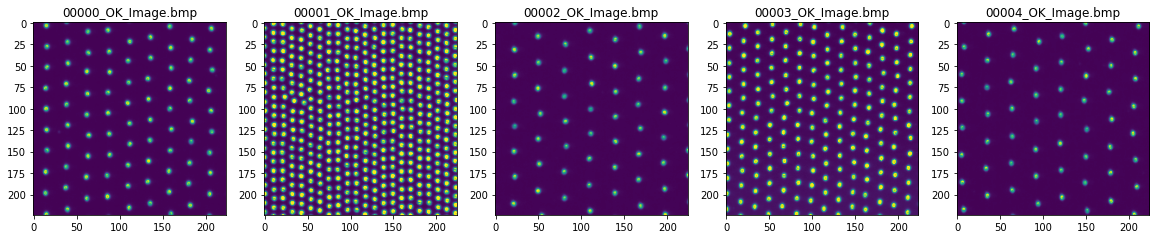

In [4]:
plt.figure(figsize = (20, 20))
print_random_images(path_img_ok)

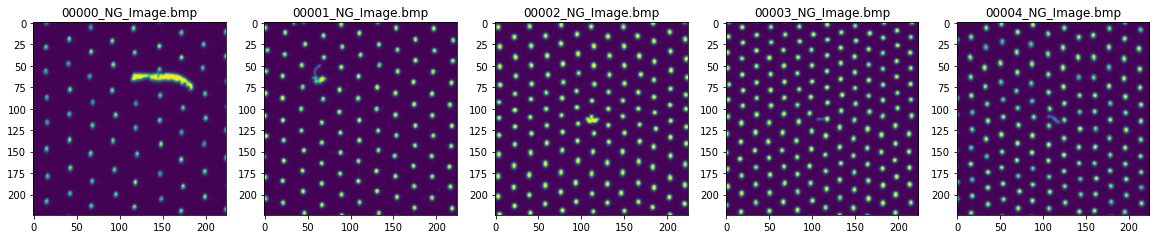

In [5]:
plt.figure(figsize = (20, 20))
print_random_images(path_img_ko)

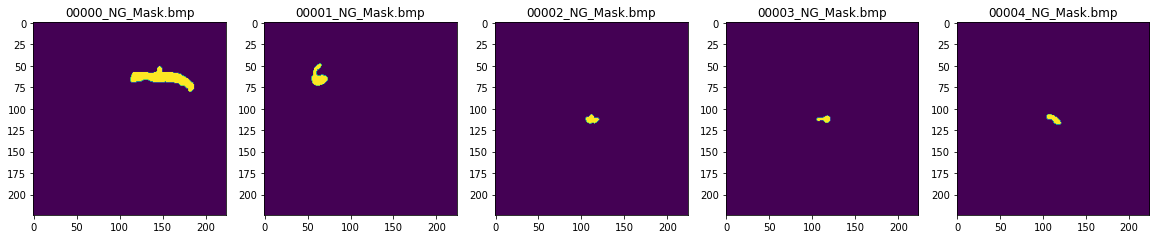

In [6]:
plt.figure(figsize = (20, 20))
print_random_images(path_msk_ko)

Dataframe creation

In [8]:
img_dataset_ok = []
img_dataset_ko = []
msk_dataset_ok = []
msk_dataset_ko = []

In [668]:
IMG_WIDTH=128
IMG_HEIGHT=128

def create_dataset(img_folder, bnw, binary):
    img_data_array = []
    color_str = cv2.IMREAD_COLOR
    color_int = 3
    if(bnw):
        color_str = cv2.cv2.IMREAD_GRAYSCALE
        color_int = 1
    for file in sorted(os.listdir(img_folder)):
            image_path = os.path.join(img_folder, file)
            image = cv2.imread(image_path, color_str)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image = np.array(image)
            image = image.astype('float32')
            image /= 255
            image = np.reshape(image, (IMG_WIDTH,IMG_HEIGHT,color_int))
            if(bnw):
                image = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)[1]
            if(binary):
                image = image.tobytes()
            img_data_array.append(image)
    return img_data_array

In [669]:
# extract the image array and class name
img_dataset_ok = create_dataset(path_img_ok, False, False)
img_dataset_ko = create_dataset(path_img_ko, False, False)
msk_dataset_ok = create_dataset(path_msk_ok, True, False)
msk_dataset_ko = create_dataset(path_msk_ko, True, False)

img_dataset_ok_bin = create_dataset(path_img_ok, False, True)
img_dataset_ko_bin = create_dataset(path_img_ko, False, True)
msk_dataset_ok_bin = create_dataset(path_msk_ok, True, True)
msk_dataset_ko_bin = create_dataset(path_msk_ko, True, True)

Check correcteness of the array content

(128, 128, 3)


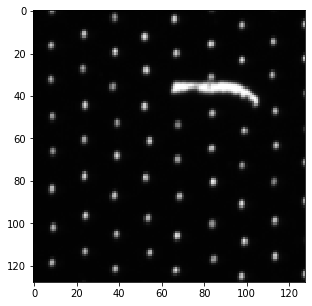

In [670]:
plt.figure(figsize = (5, 5))
plt.imshow(img_dataset_ko[0], interpolation='nearest')
print(img_dataset_ko[0].shape)

0.0 1.0


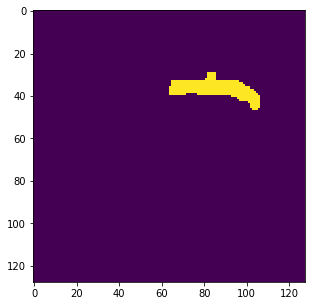

In [671]:
plt.figure(figsize = (5, 5))
plt.imshow(msk_dataset_ko[0], interpolation='nearest')
print(np.amin(msk_dataset_ko[0]), np.amax(msk_dataset_ko[0]))
#print(msk_dataset_ko[0].shape)

Dataframe creation with images stored as binary

In [543]:
df_img_dataset_ok = pd.DataFrame(columns = ['image','label'])
df_img_dataset_ok['image'] = img_dataset_ok_bin
df_img_dataset_ok['label'] = 0
#df_img_dataset_ok

In [544]:
df_img_dataset_ko = pd.DataFrame(columns = ['image','label'])
df_img_dataset_ko['image'] = img_dataset_ko_bin
df_img_dataset_ko['label'] = 1
#df_img_dataset_ko

In [545]:
df_msk_dataset_ok = pd.DataFrame(columns = ['mask'])
df_msk_dataset_ok['mask'] = msk_dataset_ok_bin
#df_msk_dataset_ok

In [546]:
df_msk_dataset_ko = pd.DataFrame(columns = ['mask'])
df_msk_dataset_ko['mask'] = msk_dataset_ko_bin
#df_msk_dataset_ok

In [547]:
df_img_dataset_tot = pd.concat([df_img_dataset_ok,df_img_dataset_ko], ignore_index=True)
df_msk_dataset_tot = pd.concat([df_msk_dataset_ok,df_msk_dataset_ko], ignore_index=True)

In [548]:
df_dataset_tot = pd.merge(df_img_dataset_tot, df_msk_dataset_tot, left_index=True, right_index=True)

Check dataframe content deconding the images:

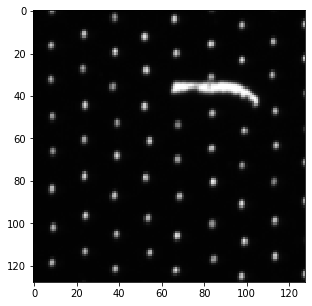

In [550]:
plt.figure(figsize = (5, 5))
img = np.frombuffer(df_dataset_tot[df_dataset_tot.label==1]['image'].iloc[0], dtype=np.float32)
img = np.reshape(img, (IMG_WIDTH,IMG_HEIGHT,3))
plt.imshow(img, interpolation='nearest')

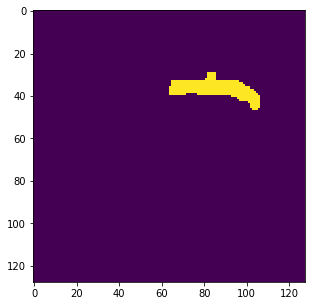

In [476]:
plt.figure(figsize = (5, 5))
img = np.frombuffer(df_dataset_tot[df_dataset_tot.label==1]['mask'].iloc[0], dtype=np.float32)
img = np.reshape(img, (IMG_WIDTH,IMG_HEIGHT,1))
plt.imshow(img, interpolation='nearest')

Reshuffle and split the dataframe

In [477]:
df_dataset_tot = df_dataset_tot.sample(frac=1).reset_index(drop=True)

In [478]:
df_dataset_train, df_dataset_test = train_test_split(df_dataset_tot, test_size=0.97, random_state=25)

In [479]:
df_dataset_val, df_dataset_test = train_test_split(df_dataset_test, test_size=0.97, random_state=25)

In [179]:
df_dataset_train.groupby("label")['image'].count()

label
0    14
1    10
Name: image, dtype: int64

In [180]:
df_dataset_test.groupby("label")['image'].count()

label
0    375
1    400
Name: image, dtype: int64

In [181]:
df_dataset_val.groupby("label")['image'].count()

label
0    11
1    12
Name: image, dtype: int64

In [701]:
print(f"No. of training examples: {df_dataset_train.shape[0]}")
print(f"No. of testing examples: {df_dataset_test.shape[0]}")
print(f"No. of validation examples: {df_dataset_val.shape[0]}")

No. of training examples: 24
No. of testing examples: 775
No. of validation examples: 23


Convert back images and create corresponding arrays of images

In [480]:
def convert_back(df, type, color_int):
    temp_arr = []
    for i in df[type].values:
        a = np.frombuffer(i, dtype=np.float32)
        a = a.reshape(IMG_WIDTH,IMG_HEIGHT,color_int)
        temp_arr.append(a)
        #print(a.shape)
    return temp_arr

img_train = convert_back(df_dataset_train, 'image', 3)
img_test = convert_back(df_dataset_test, 'image', 3)
img_val = convert_back(df_dataset_val, 'image', 3)

msk_train = convert_back(df_dataset_train, 'mask', 1)
msk_test = convert_back(df_dataset_test, 'mask', 1)
msk_val = convert_back(df_dataset_val, 'mask', 1)

print(len(img_train), len(msk_train))
print(len(img_test), len(msk_test))
print(len(img_val), len(msk_val))

print(img_train[0].shape, msk_train[0].shape)
print(img_test[0].shape, msk_test[0].shape)
print(img_val[0].shape, msk_val[0].shape)

24 24
775 775
23 23
(128, 128, 3) (128, 128, 1)
(128, 128, 3) (128, 128, 1)
(128, 128, 3) (128, 128, 1)


(128, 128, 3)


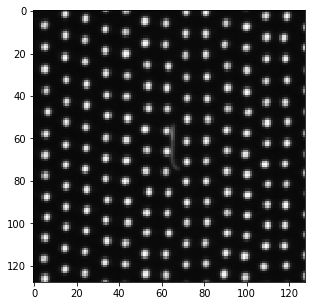

In [514]:
plt.figure(figsize = (5, 5))
plt.imshow(img_test[0], interpolation='nearest')
#print(img_test[0])
print(img_test[0].shape)

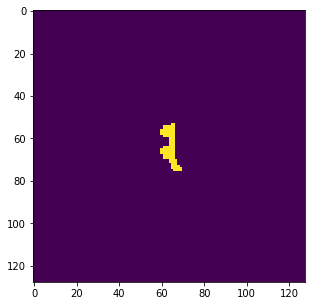

In [512]:
plt.figure(figsize = (5, 5))
plt.imshow(msk_test[0], interpolation='nearest')
#print(msk_test[0])

Build the model (U-Net)

In [486]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [487]:
import tensorflow_datasets
from tensorflow_examples.models.pix2pix import pix2pix
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [488]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [770]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

In [716]:
#tf.keras.utils.plot_model(model, show_shapes=True)

Build the sample weights for weighing the loss function and take into account imbalanced date

In [717]:
class_weights = tf.constant([1.0, 1000.0])
class_weights = class_weights/tf.reduce_sum(class_weights)

In [718]:
sample_weights = tf.gather(class_weights, indices=tf.cast(msk_train, tf.int32))

In [719]:
print(np.amin(sample_weights), np.amax(sample_weights))
sample_weights.shape

0.000999001 0.999001


TensorShape([24, 128, 128, 1])

0.00990099 0.990099


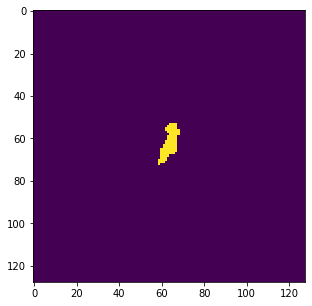

In [617]:
plt.figure(figsize = (5, 5))
plt.imshow(sample_weights[1], interpolation='nearest')
print(np.amin(sample_weights[1]), np.amax(sample_weights[1]))
#print(msk_test[0])

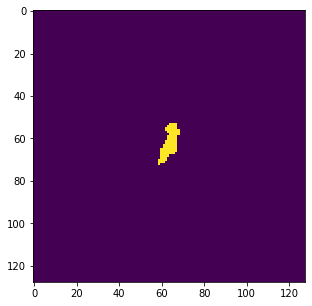

In [616]:
plt.figure(figsize = (5, 5))
plt.imshow(msk_train[1], interpolation='nearest')
#print(msk_test[0])

Train the model

In [771]:
EPOCHS = 100

model_history = model.fit(
    x=np.array(img_train, np.float32) 
    ,y=np.array(msk_train, np.float32)
    ,epochs=EPOCHS
    #,steps_per_epoch=STEPS_PER_EPOCH
    #,validation_steps=VALIDATION_STEPS
    ,validation_data=(np.array(img_val, np.float32), np.array(msk_val, np.float32))
    #,callbacks=[DisplayCallback()]
    ,sample_weight=np.array(sample_weights, np.float32)
    )

Epoch 1/100
1/1 [==============================] - 13s 13s/step - loss: 0.0034 - accuracy: 0.8550 - val_loss: 0.5794 - val_accuracy: 0.7054
Epoch 2/100
1/1 [==============================] - 4s 4s/step - loss: 0.0023 - accuracy: 0.7234 - val_loss: 0.7667 - val_accuracy: 0.4908
Epoch 3/100
1/1 [==============================] - 3s 3s/step - loss: 0.0016 - accuracy: 0.5203 - val_loss: 0.9441 - val_accuracy: 0.3432
Epoch 4/100
1/1 [==============================] - 3s 3s/step - loss: 0.0015 - accuracy: 0.3700 - val_loss: 1.0702 - val_accuracy: 0.2233
Epoch 5/100
1/1 [==============================] - 3s 3s/step - loss: 0.0014 - accuracy: 0.2624 - val_loss: 1.1289 - val_accuracy: 0.1902
Epoch 6/100
1/1 [==============================] - 3s 3s/step - loss: 0.0014 - accuracy: 0.2186 - val_loss: 1.1253 - val_accuracy: 0.2067
Epoch 7/100
1/1 [==============================] - 3s 3s/step - loss: 0.0013 - accuracy: 0.2374 - val_loss: 1.0747 - val_accuracy: 0.2624
Epoch 8/100
1/1 [===============

1/1 [==============================] - 3s 3s/step - loss: 5.4190e-05 - accuracy: 0.9952 - val_loss: 0.0321 - val_accuracy: 0.9985
Epoch 59/100
1/1 [==============================] - 3s 3s/step - loss: 5.2386e-05 - accuracy: 0.9953 - val_loss: 0.0309 - val_accuracy: 0.9984
Epoch 60/100
1/1 [==============================] - 3s 3s/step - loss: 5.0739e-05 - accuracy: 0.9954 - val_loss: 0.0298 - val_accuracy: 0.9984
Epoch 61/100
1/1 [==============================] - 3s 3s/step - loss: 4.9188e-05 - accuracy: 0.9954 - val_loss: 0.0288 - val_accuracy: 0.9984
Epoch 62/100
1/1 [==============================] - 3s 3s/step - loss: 4.7677e-05 - accuracy: 0.9955 - val_loss: 0.0278 - val_accuracy: 0.9984
Epoch 63/100
1/1 [==============================] - 3s 3s/step - loss: 4.6246e-05 - accuracy: 0.9956 - val_loss: 0.0269 - val_accuracy: 0.9984
Epoch 64/100
1/1 [==============================] - 3s 3s/step - loss: 4.4862e-05 - accuracy: 0.9956 - val_loss: 0.0259 - val_accuracy: 0.9984
Epoch 65/100

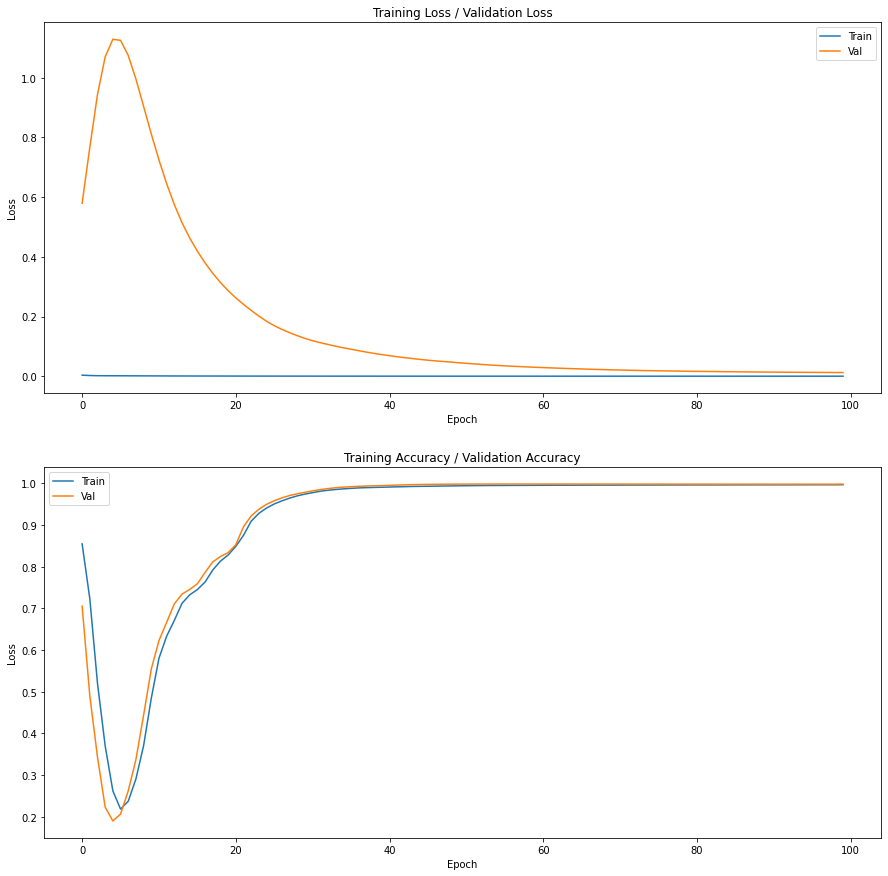

In [772]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(model_history.history['loss'])
axs[0].plot(model_history.history['val_loss'])
axs[0].title.set_text('Training Loss / Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(model_history.history['accuracy'])
axs[1].plot(model_history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy / Validation Accuracy')
axs[1].legend(['Train', 'Val'])

a = plt.setp(axs[0], xlabel='Epoch')
a = plt.setp(axs[0], ylabel='Loss')
a = plt.setp(axs[1], xlabel='Epoch')
a = plt.setp(axs[1], ylabel='Loss')

In [493]:
score = model.evaluate(np.array(img_test, np.float32), np.array(msk_test, np.float32))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

25/25 [==============================] - 35s 1s/step - loss: 0.0239 - accuracy: 0.9973
Test loss: 0.02387101948261261
Test accuracy: 0.9972856044769287


Check predictions

In [773]:
pred_mask_train = model.predict((np.array(img_train, np.float32)))

In [774]:
pred_mask_val = model.predict((np.array(img_val, np.float32)))

In [775]:
pred_mask_test = model.predict((np.array(img_test, np.float32)))

In [107]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), 'gray')
    plt.axis('off')
  plt.show()

In [842]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = (np.array(pred_mask, np.float32)*255).astype(np.uint8)
    blur = cv2.GaussianBlur(pred_mask,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv.THRESH_OTSU)
    th3 = th3.reshape(IMG_WIDTH,IMG_HEIGHT,1)
    print(th3.shape)
    return th3

(128, 128, 1)


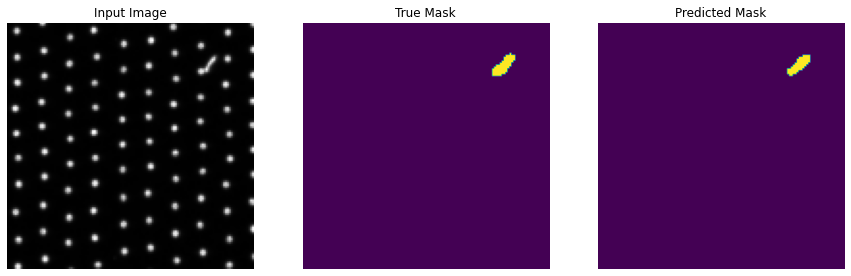

In [843]:
i = 8
pred = create_mask(pred_mask_train[i])
a = (np.array(img_train[i], np.float32))
b = (np.array(msk_train[i], np.float32))
c = (np.array(pred, np.float32))

display([a, b, c])

(128, 128, 1)


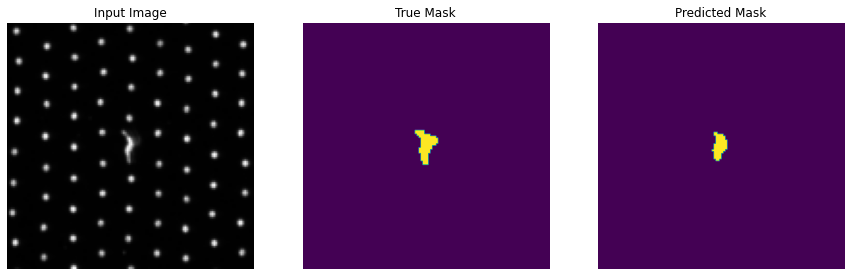

In [858]:
i = 17
pred = create_mask(pred_mask_val[i])
a = (np.array(img_val[i], np.float32))
b = (np.array(msk_val[i], np.float32))
c = (np.array(pred, np.float32))

display([a, b, c])

(128, 128, 1)


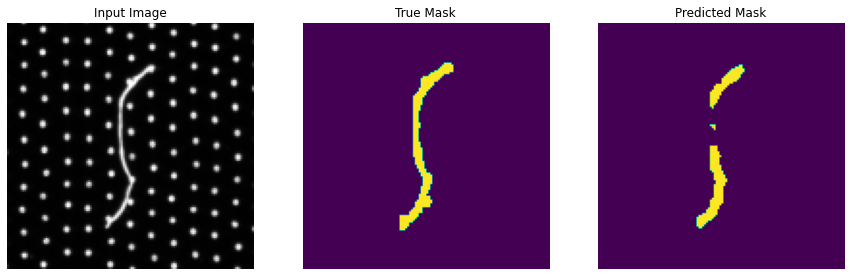

In [835]:
i = 600
pred = create_mask(pred_mask_test[i])
a = (np.array(img_test[i], np.float32))
b = (np.array(msk_test[i], np.float32))
c = (np.array(pred, np.float32))

display([a, b, c])

-----------------------

In [121]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

2022-03-23 12:07:28.740201: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /Users/I559573/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete3KCSTM/oxford_iiit_pet-train.tfre…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /Users/I559573/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete3KCSTM/oxford_iiit_pet-test.tfrec…

Dataset oxford_iiit_pet downloaded and prepared to /Users/I559573/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [187]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [188]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [189]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [190]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [191]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [260]:
for example in train_images.take(5):
    image, label = example[0], example[1]
    print(image.shape)
    print(label.shape)
    print(np.amin(label), np.amax(label))

(128, 128, 3)
(128, 128, 1)
0.0 2.0
(128, 128, 3)
(128, 128, 1)
0.0 2.0
(128, 128, 3)
(128, 128, 1)
0.0 2.0
(128, 128, 3)
(128, 128, 1)
0.0 2.0
(128, 128, 3)
(128, 128, 1)
0.0 2.0


In [261]:
for example in dataset["train"].take(5):
    image, label = example["image"], example["segmentation_mask"]
    print(image.shape)
    print(label.shape)
    print(np.amin(label), np.amax(label))

(500, 500, 3)
(500, 500, 1)
1 3
(313, 500, 3)
(313, 500, 1)
1 3
(500, 333, 3)
(500, 333, 1)
1 3
(375, 500, 3)
(375, 500, 1)
1 3
(500, 333, 3)
(500, 333, 1)
1 3


In [568]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

In [193]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


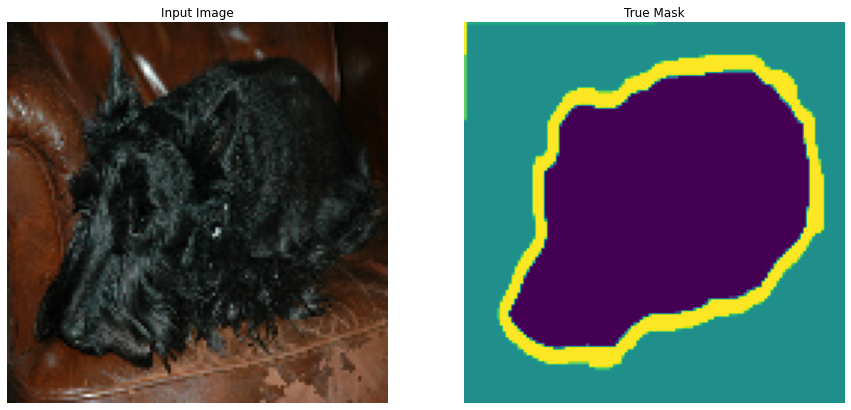

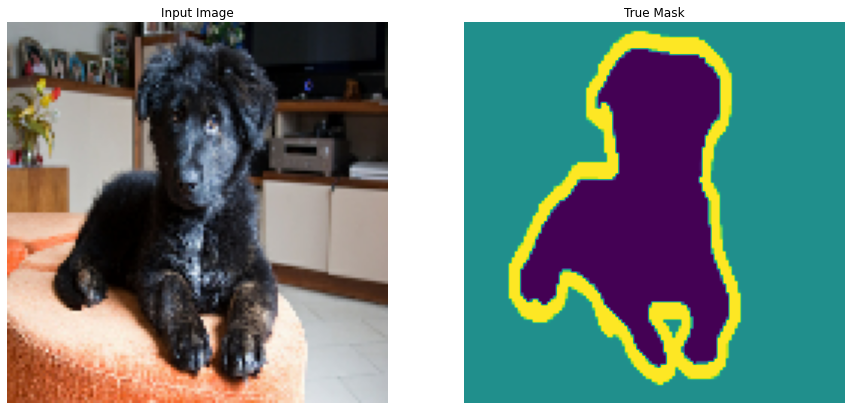

2022-03-23 18:28:20.808441: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [217]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[63], masks[63]
  display([sample_image, sample_mask])

In [555]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [569]:
train_batches.map(add_sample_weights).element_spec
train_batches1 = train_batches.map(add_sample_weights)

In [571]:
for example in train_batches1.take(1):
    image, label, weights = example[0], example[1], example[2]
    print(image.shape)
    print(label.shape)
    print(weights.shape)
    print(np.amin(label), np.amax(label))
    print(np.amin(weights), np.amax(weights))

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


(64, 128, 128, 3)
(64, 128, 128, 1)
(64, 128, 128, 1)
0.0 2.0
0.2 0.4


2022-03-24 16:52:54.352767: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [575]:
class_weights = tf.constant([1.0, 10.0])
class_weights = class_weights/tf.reduce_sum(class_weights)

In [576]:
print(class_weights)

tf.Tensor([0.09090909 0.90909094], shape=(2,), dtype=float32)


In [595]:
tf.cast(img_train, tf.int32)
sample_weights = tf.gather(class_weights, indices=tf.cast(msk_train, tf.int32))

In [700]:
print(type(sample_weights))
print(np.amin(sample_weights), np.amax(sample_weights))

<class 'tensorflow.python.framework.ops.EagerTensor'>
0.000999001 0.999001


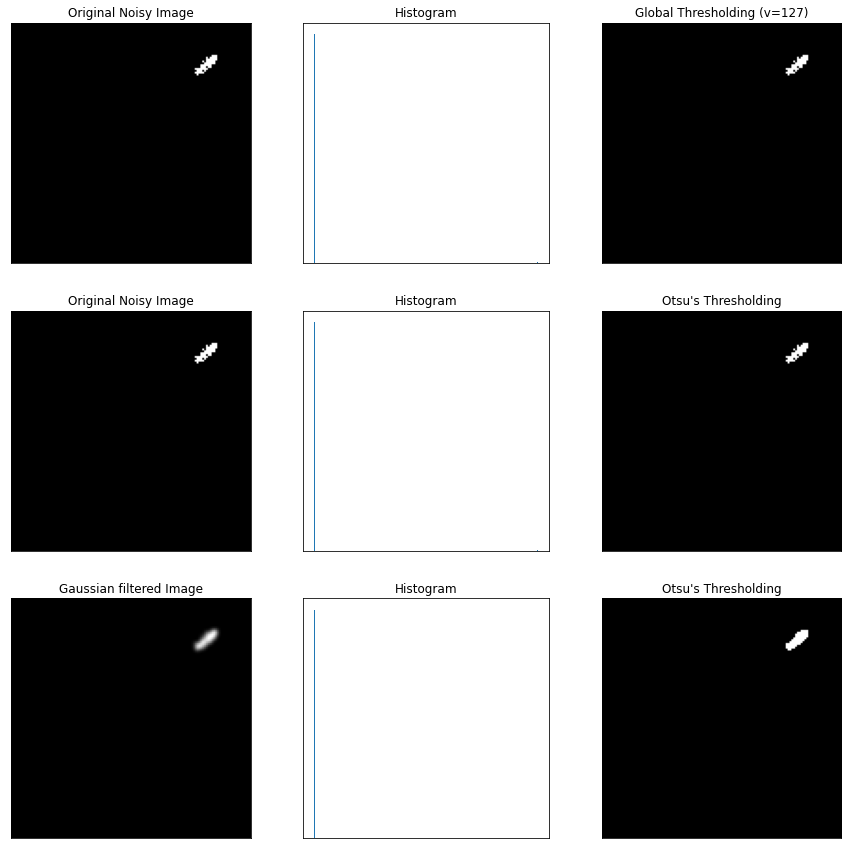

In [823]:
import cv2 as cv
import glob

path_normal_images = glob.glob("../data/Images/OK/*")
path_abnormal_images = glob.glob("../data/Images/NG/*")

#img = cv.imread(path_abnormal_images[0],0)
img = (np.array(pred, np.float32)*255).astype(np.uint8)

# global thresholding
ret1,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv.GaussianBlur(img,(5,5),0)
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

fig, axs = plt.subplots(3, 3, figsize=(15,15))
for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])

plt.show()